In [2]:
import pandas as pd
import copulogram as cp
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy as sc
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
tfb=tfp.bijectors
from scipy import io
import time
import matplotlib.pyplot as plt
from sklearn import mixture
import joblib as jbl
import sys
import sklearn
import pandas as pd
import seaborn as sns
from pathlib import Path
from mixture_models import GMCM, GMC
import utils as utl
import os
from scipy.stats import multivariate_normal
import rpy2
from transport import transport, extract_marginal_gmms, obtain_quantiles_weights

In [3]:
import random
random.seed(2910251)

Load Dataset

Breast Cancer

In [4]:

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# Read the CSV file from the URL
df = pd.read_csv(url, header=None)

# Select the columns
df = df.iloc[:,[1,14,26,28,29]]
df.columns = ["diagnosis","EC","ECP"," PSE","ES"]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


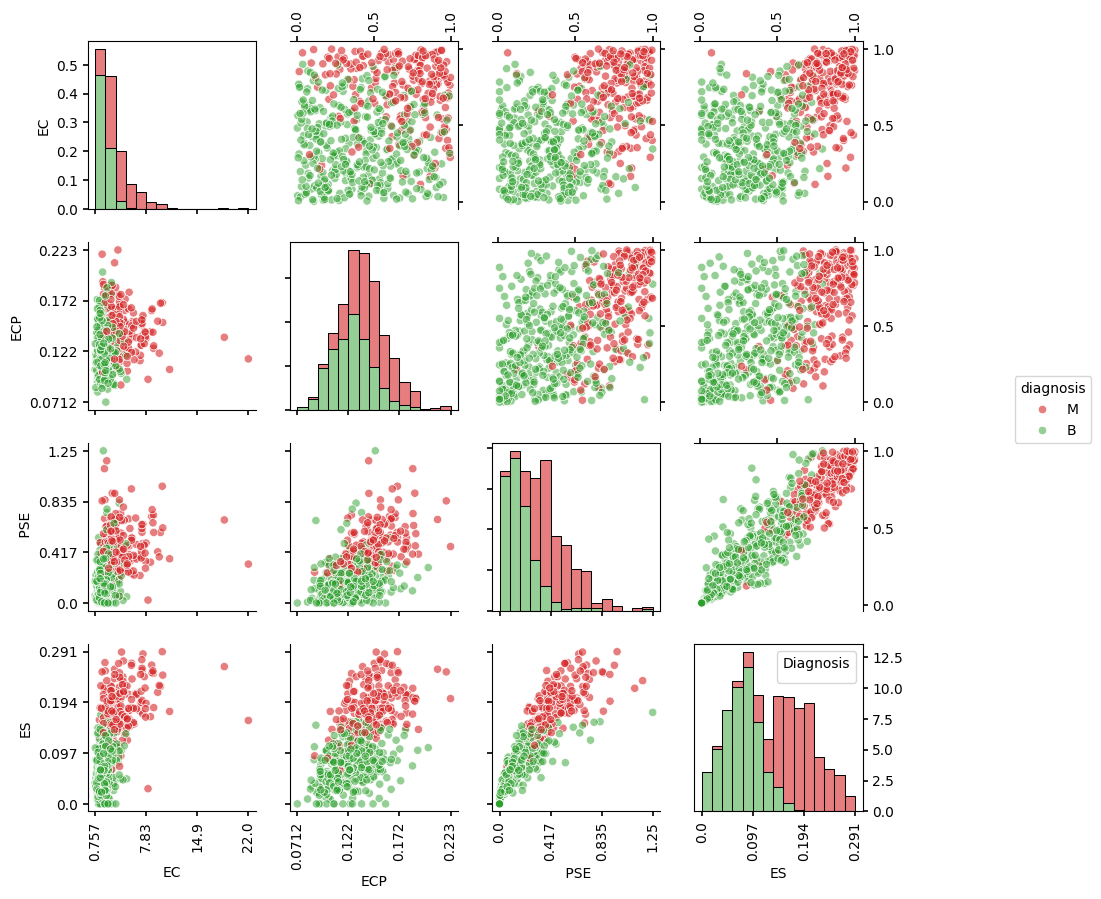

In [5]:
os.chdir("C:\\Users\\antoi\\Downloads")
color_palette = sns.color_palette([to_rgba('C3', 0.6), to_rgba('C2', 0.5)], as_cmap=True)
copulogram = cp.Copulogram(df)
copulogram.draw(hue='diagnosis', hue_colorbar=color_palette)
plt.legend(title='Diagnosis')  # Adjust the title or other legend properties as needed

plt.savefig("descriptive_breast_cancer.png", bbox_inches='tight')  # Use bbox_inches='tight' to fit everything

In [6]:

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"

# Read the CSV file from the URL
df = pd.read_csv(url, header=None)

# Select the columns
df = df.iloc[:,[14,26,28,29]]
df.columns = ["14","26","28","29"]
data = df.astype('float32').to_numpy()

In [7]:
nsamps,ndims = data.shape
n_comps = 2

Define dimension and number of modes

Split the dataset and train the GMCM

In [8]:
data_trn,data_vld,data_tst = utl.splitData(data)

print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

gmcm = GMCM(ndims)
gmcm.fit_dist_IFM(data_trn,
                n_comps=n_comps,
                method="GMCM",
                data_vld= None,# fixed number of components
                batch_size=10,
                max_iters=6001,
                regularize=True,
                init = 'gmm', #(init option: 'gmm' warm starts gmcm learning compared to 'random')
                print_interval=1000)

Number of samples = 569, Number of dimensions = 4
Learning Marginals
Marginals learnt in 6.74 s.
@ Iter:0,                         Training error: -12.1,                         Validation error: nan,                         Time Elapsed: 7.5 s
@ Iter:1000,                         Training error: -12.1,                         Validation error: nan,                         Time Elapsed: 15.0 s
@ Iter:2000,                         Training error: -12.2,                         Validation error: nan,                         Time Elapsed: 22.2 s
@ Iter:3000,                         Training error: -13.1,                         Validation error: nan,                         Time Elapsed: 29.2 s
@ Iter:4000,                         Training error: -12.8,                         Validation error: nan,                         Time Elapsed: 36.2 s
@ Iter:5000,                         Training error: -12.7,                         Validation error: nan,                         Time Elapsed: 43

Extract parameters

In [9]:
list_indexes =  range(ndims)   ## depends on the problem
logits,mus,covs,_ = utl.vec2gmm_params(gmcm.ndims,gmcm.ncomps,gmcm.gmc.params)
alphas = tf.math.softmax(logits)
#dim_remove = list(set(list(range(self.ndims)))-set(dim_list))
mus_new = tf.gather(mus,list_indexes, axis=1)
covs_new = tf.TensorArray(tf.float32,gmcm.ncomps)
for k in range(gmcm.ncomps):
    temp_mat = covs[k].numpy()
    covs_new = covs_new.write(k,temp_mat[np.ix_(list_indexes, list_indexes)])
covs_new = covs_new.stack()

Transform to latent space

In [10]:
data_tst_uniform = gmcm.marg_bijector.inverse(data_tst)
data_tst_latent = gmcm.gmc.distribution.bijector.inverse(data_tst_uniform)

Define dimension to predict

In [11]:
dimension_predict = 2
dimension_joint = ndims

In [12]:
os.chdir('C:\\Users\\antoi\\Downloads\\GMCM-main\\GMCM-main')
from transport import transport, extract_marginal_gmms, obtain_quantiles_weights

In [13]:
# Obtain parameters for marginals and for latents
quantiles_weights_list = obtain_quantiles_weights(gmcm)
marg_info_list = extract_marginal_gmms(gmcm) # this works fine
logits, mus, covs,_ = utl.vec2gmm_params(gmcm.ndims,gmcm.ncomps,gmcm.gmc.params)
latent_weights = tf.math.softmax(logits)

In [14]:

size_test = np.shape(data_tst)[0] # size of the test dataset
n_samples = 1000 # number of samples from the conditional distribution that we want to get
cond_samples_gmcm = []
from scipy.stats import multivariate_normal

# Obtain parameters for marginals and for latents
quantiles_weights_list = obtain_quantiles_weights(gmcm)
marg_info_list = extract_marginal_gmms(gmcm) # this works fine
logits, mus, covs,_ = utl.vec2gmm_params(gmcm.ndims,gmcm.ncomps,gmcm.gmc.params)
latent_weights = tf.math.softmax(logits)

# Let's precompute the matrices required
Sigma22_inv_list = []
Sigma12_Sigma22_inv_list = []
cov_cond_list = []
for j in range(n_comps):
    cov_matrix = covs_new[j].numpy()
    Sigma22 = cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint]
    Sigma12 = cov_matrix[:dimension_predict, dimension_predict:dimension_joint]
    Sigma11 = cov_matrix[:dimension_predict, :dimension_predict]
    Sigma22_inv = np.linalg.inv(Sigma22)
    Sigma12_Sigma22_inv = Sigma12 @ Sigma22_inv
    cov_cond = Sigma11 - Sigma12_Sigma22_inv @ Sigma12.T
    Sigma12_Sigma22_inv_list.append(Sigma12_Sigma22_inv)
    cov_cond_list.append(cov_cond)
parameters = []
for i in range(0,size_test):
    mean_conds = np.zeros(n_comps)
    cov_conds = np.zeros(n_comps)
    risk_vector_gmcm = np.zeros((n_samples,dimension_joint))
    conditioning_value = data_tst_latent[i,dimension_predict:dimension_joint].numpy() # condition on last variables
    new_alphas = np.zeros(n_comps)
    risk_vector_gmcm = np.zeros((n_samples, dimension_joint))
    for j in range(0,n_comps):
        # margin for one of the components
        marginal = multivariate_normal.pdf(
            conditioning_value,
            mean = mus_new[j][dimension_predict:dimension_joint], 
            cov = covs_new[j][dimension_predict:dimension_joint,dimension_predict:dimension_joint])
        # what's this do? compute the *total* marginal density, aggregated over all components?
        joint = 0
        for k in range(0,n_comps):
            joint += alphas[k] * multivariate_normal.pdf(
                conditioning_value, mean = mus_new[k][dimension_predict:dimension_joint], 
                cov = covs_new[k][dimension_predict:dimension_joint,dimension_predict:dimension_joint]
            )
        # What are 'new alphas'? Is this just prior * likelihood? I.e., prob of a cluster given known values?
        if joint != 0:
            new_alphas[j] = alphas[j] * (marginal / joint)
        else:
            new_alphas[j] = 0
    
    # Deal with rounding error; if new_alphas.sum() == 0, there's a problem somewhere :)
    new_alphas /= new_alphas.sum()
    # For each sample, pick a cluster
    component_choices = np.random.choice(n_comps, size = n_samples, p = new_alphas)
    risk_vector_gmcm = np.zeros((n_samples, dimension_joint))
    for j in range(0, n_comps):
        mask = component_choices == j
        n_j = np.sum(mask)
        if n_j == 0:
            continue
        mean_vector = mus_new[j].numpy()
        Sigma12_Sigma22_inv = Sigma12_Sigma22_inv_list[j]
        cov_cond = cov_cond_list[j]
        conditioning_diff = conditioning_value - mean_vector[dimension_predict:dimension_joint]
        conditioning_diff = conditioning_diff[:, np.newaxis]
        mean_cond_batch = mean_vector[:dimension_predict] + (Sigma12_Sigma22_inv @ conditioning_diff).flatten()
        # generate Normal data (in latent space) with required mean and sigma
        samples = np.random.multivariate_normal(mean = mean_cond_batch, cov = cov_cond, size = n_j)
        risk_vector_gmcm[mask, :dimension_predict] = samples
        #mean_conds[j] = mean_cond_batch
        #cov_conds [j] = cov_cond
    risk_vector_gmcm[:, dimension_predict:dimension_joint] = conditioning_value
    #print(i)
    risk_vector_gmcm = risk_vector_gmcm.astype('float32')
    risk_vector_gmcm = gmcm.gmc.distribution.bijector(risk_vector_gmcm) # to copula (uniform) space
    risk_vector_gmcm = gmcm.marg_bijector(risk_vector_gmcm) # transform marginals
    #risk_vector_gmcm = transport(risk_vector_gmcm, marg_info_list, latent_weights, mus, covs, quantiles_weights_list)
    cond_samples_gmcm.append(risk_vector_gmcm)
    #parameters.append([new_alphas,mean_conds,cov_conds])

Competitors

In [15]:
n_comps=1
nsamps,ndims = data.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

gc= GMCM(ndims)
gc.fit_dist_IFM(data_trn,
                 n_comps=n_comps,
                 method="GC",
                 data_vld= None,# fixed number of components
                                    batch_size=10,
                                    max_iters=6001,
                                    regularize=True,
                                    init = 'gmm', #(init option: 'gmm' warm starts gmcm learning compared to 'random')
                                    print_interval=1000)

Number of samples = 569, Number of dimensions = 4
Learning Marginals
Marginals learnt in 5.96 s.


In [16]:
list_indexes = list(range(ndims)) ## depends on the problem
logits,mus,covs,_ = utl.vec2gmm_params(gc.ndims,gc.ncomps,gc.gmc.params)
alphas = tf.math.softmax(logits)
#dim_remove = list(set(list(range(self.ndims)))-set(dim_list))
mus_new = tf.gather(mus,list_indexes, axis=1)
covs_new = tf.TensorArray(tf.float32,gc.ncomps)
for k in range(gc.ncomps):
    temp_mat = covs[k].numpy()
    covs_new = covs_new.write(k,temp_mat[np.ix_(list_indexes, list_indexes)])
covs_new = covs_new.stack()

In [17]:
from scipy.stats import norm
data_trn_uniform = gc.marg_bijector.inverse(data_trn)
data_trn_latent = norm.ppf(data_trn_uniform)

In [18]:
data_trn_uniform = gc.marg_bijector.inverse(data_trn)
data_trn_latent = norm.ppf(data_trn_uniform)
mean_vector = np.mean(data_trn_latent, axis=0)
cov_matrix = np.cov(data_trn_latent, rowvar=False)
Sigma22 = cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint]
Sigma12 = cov_matrix[:dimension_predict, dimension_predict:dimension_joint]
Sigma11 = cov_matrix[:dimension_predict, :dimension_predict]
Sigma22_inv = np.linalg.inv(Sigma22)
Sigma12_Sigma22_inv = Sigma12 @ Sigma22_inv
cov_cond = Sigma11 - Sigma12_Sigma22_inv @ Sigma12.T
from scipy.stats import norm, multivariate_normal as mvn
method = "GC"
if method == "GC":
    data_tst_uniform = gc.marg_bijector.inverse(data_tst)
    data_tst_latent = norm.ppf(data_tst_uniform)
    #mean_vector = mus_new[0]
    #mean_vector = np.mean(data_trn_latent)
    #cov_matrix = n
    dimension_predict = dimension_predict # dimension of the vector that we want to predict
    dimension_joint = dimension_joint # dimension of the joint distribution
    size_test = np.shape(data_tst)[0] # size of the test dataset
    n_samples = 1000 # number of samples from the conditional distribution that we want to get
    cond_samples_gc = []
    #cov_matrix = covs_new[0]
    for index in range(data_tst_latent.shape[0]):
        risk_vector_gmcm = np.zeros((n_samples,dimension_joint))
        conditioning_value = data_tst_latent[index,dimension_predict:dimension_joint]
        conditioning_diff = conditioning_value - mean_vector[dimension_predict:dimension_joint]
        conditioning_diff = conditioning_diff[:, np.newaxis]
        mean_cond_batch = mean_vector[:dimension_predict] + (Sigma12_Sigma22_inv @ conditioning_diff).flatten()
        # generate Normal data (in latent space) with required mean and sigma
        samples = np.random.multivariate_normal(mean = mean_cond_batch, cov = cov_cond, size = n_samples)
        risk_vector_gmcm[:, :dimension_predict] = samples
        risk_vector_gmcm[:,dimension_predict:dimension_joint] = conditioning_value
        risk_vector_gmcm = risk_vector_gmcm.astype('float32')
        risk_vector_gmcm = norm.cdf(risk_vector_gmcm).astype("float32")
        risk_vector_gmcm = gc.marg_bijector(risk_vector_gmcm)
        cond_samples_gc.append(risk_vector_gmcm)

TGMM

In [19]:

n_comps=2
nsamps,ndims = data.shape
print(f'Number of samples = {nsamps}, Number of dimensions = {ndims}')

tgmm = GMCM(ndims)
tgmm.fit_dist_IFM(data_trn,
                 n_comps=n_comps,
                 method="TGMM",
                 data_vld= None,# fixed number of components
                                    batch_size=10,
                                    max_iters=6001,
                                    regularize=True,
                                    init = 'gmm', #(init option: 'gmm' warm starts gmcm learning compared to 'random')
                                    print_interval=1000)

Number of samples = 569, Number of dimensions = 4
Learning Marginals
Marginals learnt in 6.59 s.


In [20]:
list_indexes = list(range(ndims)) ## depends on the problem
logits,mus,covs,_ = utl.vec2gmm_params(tgmm.ndims,tgmm.ncomps,tgmm.gmc.params)
alphas = tf.math.softmax(logits)
#dim_remove = list(set(list(range(self.ndims)))-set(dim_list))
mus_new = tf.gather(mus,list_indexes, axis=1)
covs_new = tf.TensorArray(tf.float32,tgmm.ncomps)
for k in range(tgmm.ncomps):
    temp_mat = covs[k].numpy()
    covs_new = covs_new.write(k,temp_mat[np.ix_(list_indexes, list_indexes)])
covs_new = covs_new.stack()

In [21]:
method = "TGMM"
Sigma22_inv_list = []
Sigma12_Sigma22_inv_list = []
cov_cond_list = []
for j in range(n_comps):
    cov_matrix = covs_new[j].numpy()
    Sigma22 = cov_matrix[dimension_predict:dimension_joint, dimension_predict:dimension_joint]
    Sigma12 = cov_matrix[:dimension_predict, dimension_predict:dimension_joint]
    Sigma11 = cov_matrix[:dimension_predict, :dimension_predict]
    Sigma22_inv = np.linalg.inv(Sigma22)
    Sigma12_Sigma22_inv = Sigma12 @ Sigma22_inv
    cov_cond = Sigma11 - Sigma12_Sigma22_inv @ Sigma12.T
    Sigma12_Sigma22_inv_list.append(Sigma12_Sigma22_inv)
    cov_cond_list.append(cov_cond)
if method == "TGMM":
    data_tst_uniform = tgmm.marg_bijector.inverse(data_tst)
    data_tst_latent = norm.ppf(data_tst_uniform)
    dimension_predict = dimension_predict# dimension of the vector that we want to predict
    dimension_joint = dimension_joint # dimension of the joint distribution
    size_test = np.shape(data_tst)[0] # size of the test dataset
    n_samples = 1000 # number of samples from the conditional distribution that we want to get
    cond_samples_tgmm= []
    for i in range(0,size_test):
        risk_vector_gmcm = np.zeros((n_samples,dimension_joint))
        conditioning_value = data_tst_latent[i,dimension_predict:dimension_joint]
        new_alphas = np.zeros(n_comps)
        # get new weights
        for j in range(0,n_comps):
            marginal = multivariate_normal.pdf(conditioning_value, mean= mus_new[j][dimension_predict:dimension_joint], 
                                           cov=covs_new[j][dimension_predict:dimension_joint,dimension_predict:dimension_joint])
            joint = 0
            for k in range(0,n_comps):
                joint += alphas[k] * multivariate_normal.pdf(conditioning_value, mean= mus_new[k][dimension_predict:dimension_joint], 
                                           cov=covs_new[k][dimension_predict:dimension_joint,dimension_predict:dimension_joint])
            if joint != 0:
                new_alphas[j] = alphas[j] * (marginal / joint)
            else:
                new_alphas[j] = 0
        new_alphas /= new_alphas.sum()
        component_choices = np.random.choice(n_comps, size = n_samples, p = new_alphas)
        risk_vector_gmcm = np.zeros((n_samples, dimension_joint))
        for j in range(0, n_comps):
            mask = component_choices == j
            n_j = np.sum(mask)
            if n_j == 0:
                continue
            mean_vector = mus_new[j].numpy()
            Sigma12_Sigma22_inv = Sigma12_Sigma22_inv_list[j]
            cov_cond = cov_cond_list[j]
            conditioning_diff = conditioning_value - mean_vector[dimension_predict:dimension_joint]
            conditioning_diff = conditioning_diff[:, np.newaxis]
            mean_cond_batch = mean_vector[:dimension_predict] + (Sigma12_Sigma22_inv @ conditioning_diff).flatten()
            # generate Normal data (in latent space) with required mean and sigma
            samples = np.random.multivariate_normal(mean = mean_cond_batch, cov = cov_cond, size = n_j)
            risk_vector_gmcm[mask, :dimension_predict] = samples
    
        risk_vector_gmcm[:, dimension_predict:dimension_joint] = conditioning_value
        risk_vector_gmcm = risk_vector_gmcm.astype('float32')
        risk_vector_gmcm = norm.cdf(risk_vector_gmcm).astype("float32")
        risk_vector_gmcm = tgmm.marg_bijector(risk_vector_gmcm)
        cond_samples_tgmm.append(risk_vector_gmcm)

CKDE

In [22]:
from sklearn.neighbors import KernelDensity
# Split the training data
Y_train = np.reshape(data_trn[:, :dimension_predict],(np.shape(data_trn)[0],dimension_predict))  # First three columns (targets)
X_train = np.reshape(data_trn[:, dimension_predict:dimension_joint],(np.shape(data_trn)[0],dimension_joint-dimension_predict))  # Last two columns (features)

# Combine both Y and X for KDE fitting
train_data = data_trn

# Split the test data
X_test = data_tst[:, dimension_predict:dimension_joint]  # Last two columns in test data

#### Step 2: Fit KDE Model


# Fit the KDE model on the joint data
kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(train_data)


#### Step 3: Generate Samples from the Conditional Distribution

def conditional_sample_kde(kde, X_cond, num_samples=10, tol=0.1):
    """
    Generate samples from the conditional distribution P(Y|X) using the fitted KDE.

    Parameters:
    kde -- fitted KernelDensity model
    X_cond -- ndarray of shape (n_samples, n_features)
    num_samples -- number of samples to draw for each condition
    tol -- tolerance to filter X samples close to X_cond

    Returns:
    samples -- ndarray of shape (n_samples, num_samples, n_targets)
    """
               
    n_targets = Y_train.shape[1]
    n_features = X_train.shape[1]
    
    samples = np.zeros((X_cond.shape[0], num_samples, n_targets))

    for i, x in enumerate(X_cond):
        # Generate samples from KDE
        joint_samples = kde.sample(num_samples * 100)  # Oversample initially
        
        # Split into Y and X parts
        Y_samples = joint_samples[:, :n_targets]
        X_samples = joint_samples[:, n_targets:]
        
        # Filter samples where X_samples are close to the given X_cond
        close_samples_idx = np.linalg.norm(X_samples - x, axis=1) < tol
        close_Y_samples = Y_samples[close_samples_idx]
        
        if len(close_Y_samples) < num_samples:
            raise ValueError("Not enough samples within tolerance. Increase tol or num_samples.")

        # Randomly choose the needed number of samples
        chosen_indices = np.random.choice(len(close_Y_samples), num_samples, replace=False)
        samples[i, :, :] = close_Y_samples[chosen_indices]

    return samples

# Generate samples from the conditional distribution
num_samples_per_condition = 1000# Number of samples to draw for each test example
#tol = 10# Tolerance to filter samples; adjust as needed
tol = 0.4 # Tolerance 
samples = conditional_sample_kde(kde, X_test, num_samples=num_samples_per_condition, tol=tol)

In [23]:
import scoringrules as sr
energy_score_gmcm = []
vs_score_gmcm = []
energy_score_gc = []
vs_score_gc = []
energy_score_tgmm = []
vs_score_tgmm = []
energy_score_ckde = []
vs_score_ckde = []
for i in range(size_test):
    energy_score_gmcm.append(sr.energy_score(data_tst[i,0:dimension_predict],
    cond_samples_gmcm[i][:,0:dimension_predict]))
    vs_score_gmcm.append(sr.variogram_score(data_tst[i,0:dimension_predict],
    cond_samples_gmcm[i][:,0:dimension_predict], p=0.5))
    energy_score_gc.append(sr.energy_score(data_tst[i,0:dimension_predict],
    cond_samples_gc[i][:,0:dimension_predict]))
    vs_score_gc.append(sr.variogram_score(data_tst[i,0:dimension_predict],
    cond_samples_gc[i][:,0:dimension_predict], p=0.5))
    energy_score_tgmm.append(sr.energy_score(data_tst[i,0:dimension_predict],
    cond_samples_tgmm[i][:,0:dimension_predict]))
    vs_score_tgmm.append(sr.variogram_score(data_tst[i,0:dimension_predict],
    cond_samples_tgmm[i][:,0:dimension_predict], p=0.5))
    energy_score_ckde.append(sr.energy_score(data_tst[i,0:dimension_predict],
    samples[i][:,0:dimension_predict]))
    vs_score_ckde.append(sr.variogram_score(data_tst[i,0:dimension_predict],
    samples[i][:,0:dimension_predict], p=0.5))
   

In [24]:
np.mean(energy_score_tgmm)

0.6690657

In [25]:
np.mean(energy_score_gc)

0.7259523

In [26]:
np.mean(energy_score_gmcm)

0.67187

In [27]:
np.mean(energy_score_ckde)

1.0160841473715783

In [28]:
np.mean(vs_score_tgmm)

0.28147653

In [29]:
np.mean(vs_score_gc)

0.32760888

In [30]:
np.mean(vs_score_tgmm)

0.28147653

In [31]:
np.mean(vs_score_gmcm)

0.28561345

In [32]:
np.mean(vs_score_ckde)

0.5201471876140765